In [1]:
# sourced from https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
#import missingno as msno
import os
import wget
import openpyxl
import math

In [3]:
data = pd.read_csv("percent_renewable_state.csv")
data['% Non Renewable'] = data['% Non Renewable'] * 100

In [4]:
#download US map polygons zip
#wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")

In [5]:
gdf = gpd.read_file(os.getcwd()+'/cb_2018_us_state_500k')
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [6]:
gdf = gdf.merge(data,left_on='STUSPS',right_on='State Code')

C:\Users\orptf\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


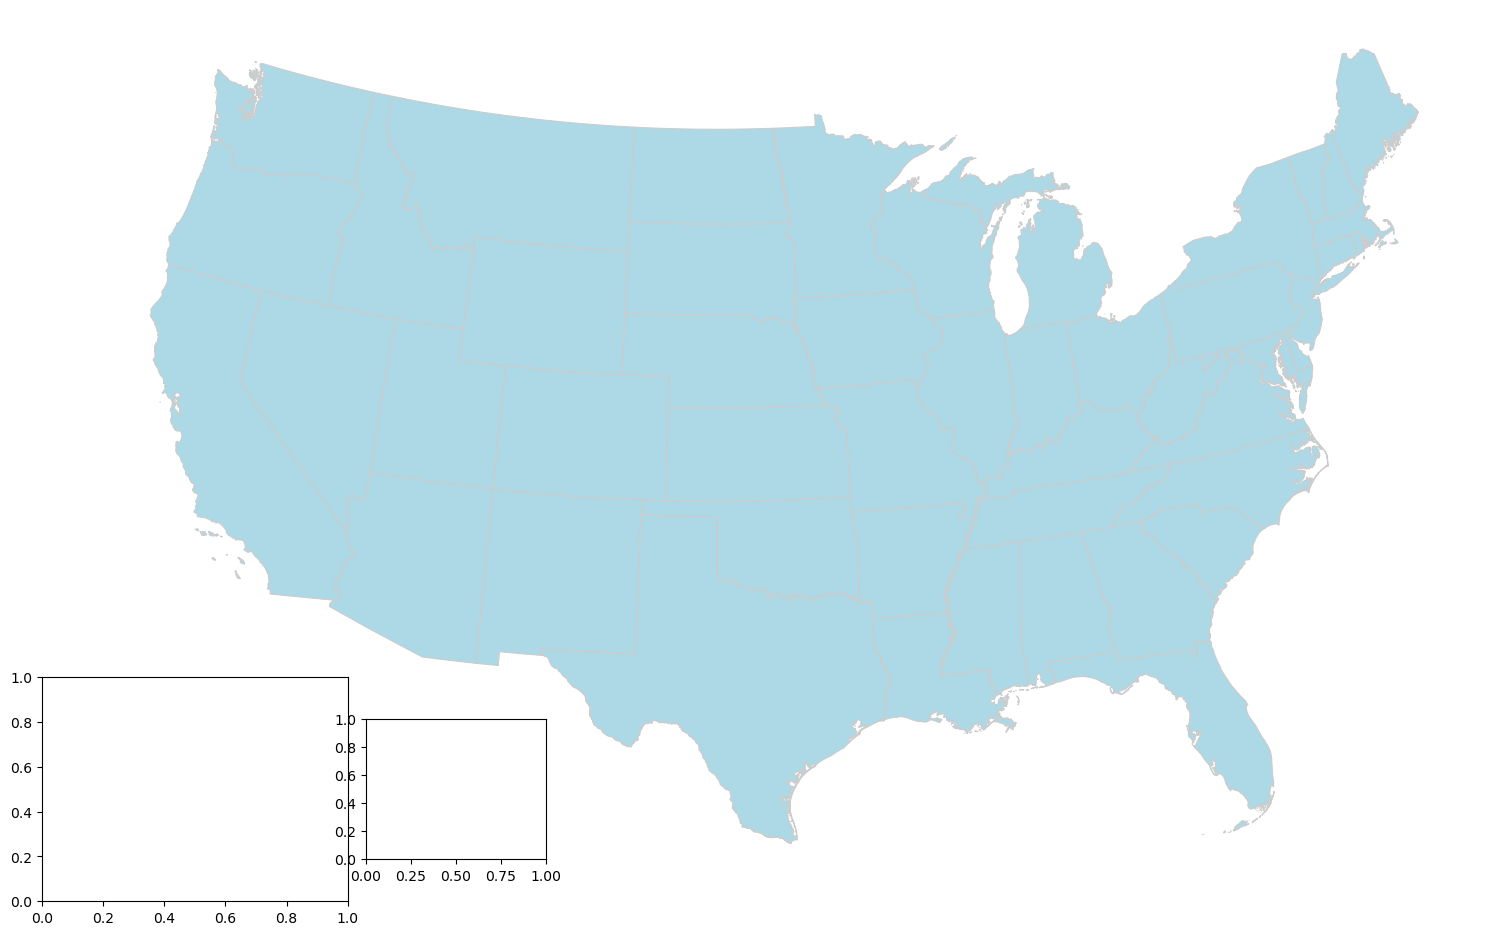

In [7]:
# Create a "copy" of gdf for re-projecting
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box from the main map
ax.axis('off')


# create map of all states except AK and HI in the main map axis
visframe[~visframe.STUSPS.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')


# Add Alaska Axis (x, y, width, height)
akax = fig.add_axes([0.1, 0.17, 0.17, 0.16])   


# Add Hawaii Axis(x, y, width, height)
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   

# We'll later map Alaska in "akax" and Hawaii in "hiax"

In [8]:
def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

C:\Users\orptf\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\orptf\AppData\Local\Temp\ipykernel_24612\3087614714.py:58: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='black')


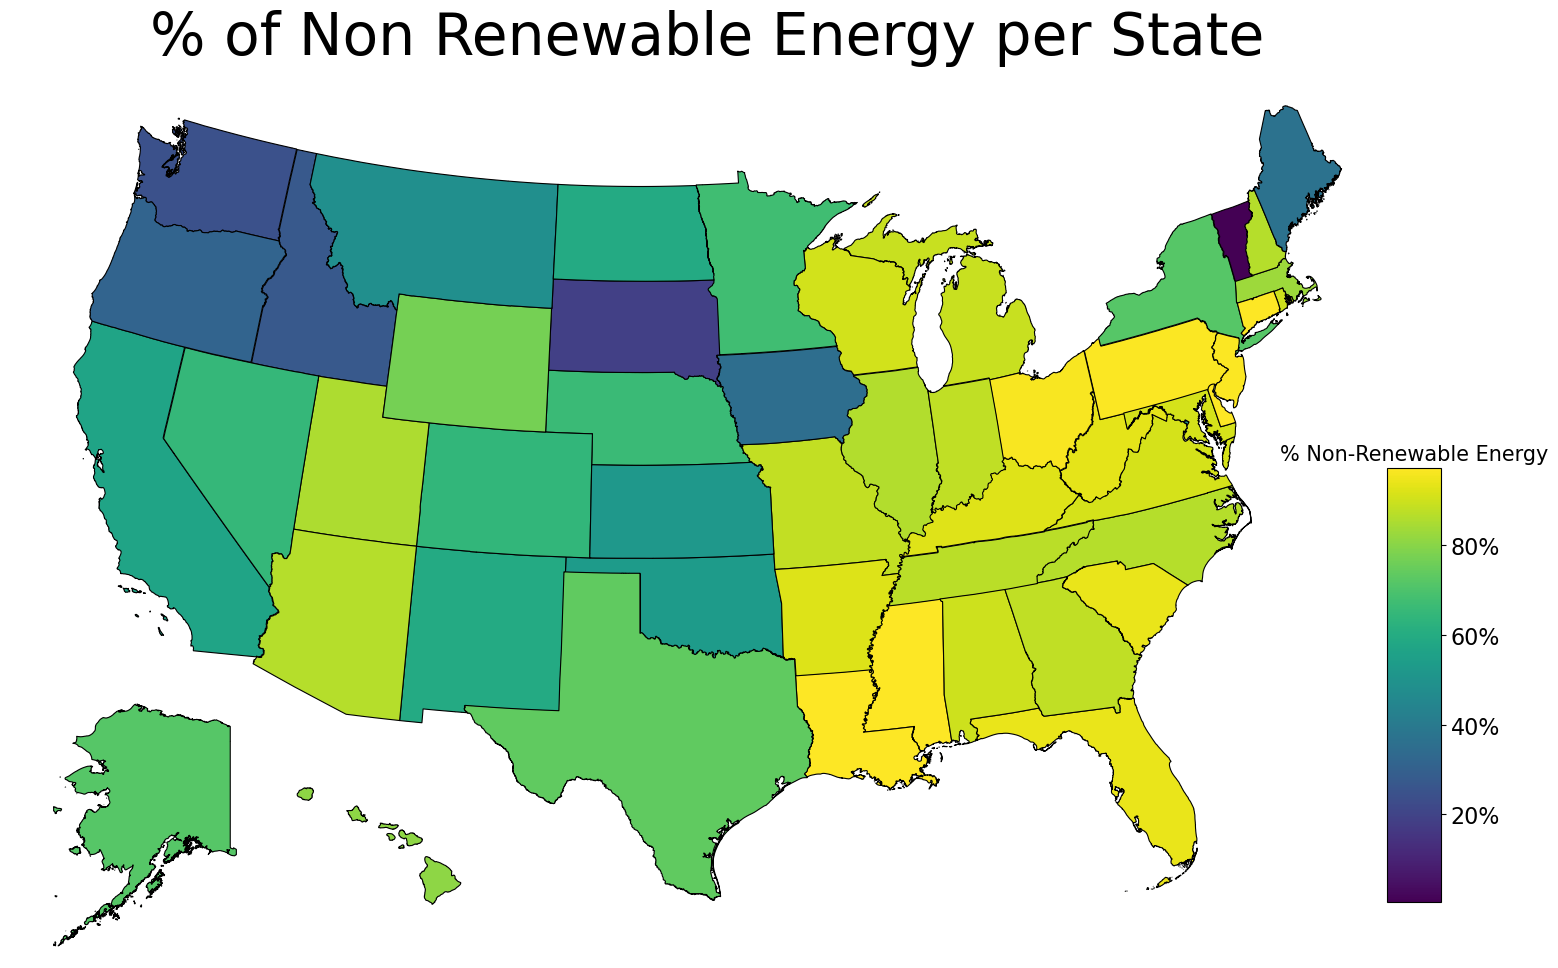

In [12]:
variable = '% Non Renewable'
vmin, vmax = gdf['% Non Renewable'].min(), gdf['% Non Renewable'].max()
colormap = "viridis"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off')

# add a title and annotation
ax.set_title('% of Non Renewable Energy per State', **hfont, fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('% Non-Renewable Energy', **hfont, fontdict={'fontsize': '15', 'fontweight' : '0'})

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
# annotate the data source, date of access, and hyperlink

# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.STUSPS not in ['AK','HI']:
        vf = visframe[visframe.STUSPS==row.STUSPS]
        c = gdf[gdf.STUSPS==row.STUSPS][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='black')
        
# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.STUSPS=='AK']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.STUSPS=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='black')

# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.STUSPS=='HI']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='black')

fig.savefig(os.getcwd()+'/color_map_power_per_state.png',dpi=400, bbox_inches="tight")